## Initial Steps for Working with GRIB Dataset in Python

### Step 1: Install Required Libraries
You will need pygrib, xarray, numpy, pandas, and matplotlib.
Use the following command to install them:
!pip install pygrib xarray numpy pandas matplotlib

In [80]:
import pygrib
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Load and Explore the GRIB Data

In [81]:
# Load the GRIB file (Replace with the path to your GRIB file)
grib_file_path = './era5_spain.grib'
backend_kwargs = {"filter_by_keys": {"shortName": "t2m"}}  # Replace "t2m" with the desired variable
grib_data = pygrib.open(grib_file_path)

In [82]:
import xarray as xr

# Load the GRIB dataset
data = xr.open_dataset('./era5_spain.grib', engine="cfgrib")

# Print available coordinates
print("Coordinates of the dataset:")
print(data.coords)

# Optionally, print specific coordinate values
print("\nLatitude values:")
print(data["latitude"].values)

print("\nLongitude values:")
print(data["longitude"].values)

# If the dataset has time:
if "time" in data.coords:
    print("\nTime values:")
    print(data["time"].values)

Ignoring index file './era5_spain.grib.5b7b6.idx' incompatible with GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 639, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1546300800, 1546344000, 1546387200, ..., 1703937600, 1703980800,
       1704024000])) new_value=Variable(dimensions=('time',), data=array([1546279200, 1546322400, 1546365600, ..., 1703916000, 1703959200,
       1704002400]))
skipping variable: paramId==182 shortName='e'
Traceback (most recent call last):
  File "/home/jonas/.local/lib/python3.10/site-packages/cfgrib/dataset.py", line 721, in build_dataset_components
    d

Coordinates of the dataset:
Coordinates:
    number               int64 8B ...
  * time                 (time) datetime64[ns] 29kB 2019-01-01 ... 2023-12-31...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * latitude             (latitude) float64 72B 44.0 43.0 42.0 ... 37.0 36.0
  * longitude            (longitude) float64 120B -10.0 -9.0 -8.0 ... 3.0 4.0
    valid_time           (time) datetime64[ns] 29kB ...
    depthBelowLandLayer  float64 8B ...

Latitude values:
[44. 43. 42. 41. 40. 39. 38. 37. 36.]

Longitude values:
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.]

Time values:
['2019-01-01T00:00:00.000000000' '2019-01-01T12:00:00.000000000'
 '2019-01-02T00:00:00.000000000' ... '2023-12-30T12:00:00.000000000'
 '2023-12-31T00:00:00.000000000' '2023-12-31T12:00:00.000000000']


## Generate labels for hot days

In [97]:
# Step 1: Restrict the dataset to May–August
data_summer = data.sel(time=data["time"].dt.month.isin([5, 6, 7, 8]))

# Step 2: Extract temperature data (e.g., variable "t2m") for the summer months
temperature_summer = data_summer["t2m"]
# Step 3: Filter temperature measurements at 12:00 within summer months
# Step 3: Filter temperature measurements at 12:00 within summer months
temp_summer_12 = temperature_summer.sel(time=temperature_summer["time"].dt.hour == 12)

# Convert the time to "day" in datetime format with time set to 00:00:00
temp_summer_12 = temp_summer_12.assign_coords(day=temp_summer_12["time"].dt.floor("D"))

# Use "day" as the main dimension
temp_summer_12 = temp_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)

# Step 4: Extract July–August temperatures for percentile calculation
temp_july_aug = temp_summer_12.sel(day=temp_summer_12["day"].dt.month.isin([7, 8]))


# Step 5: Compute the 95th percentile for each location in July–August
percentile_95 = temp_july_aug.quantile(0.95, dim="day")

# Step 6: Label hot days (May–August) based on the 95th percentile
hot_days = temp_summer_12 > percentile_95

# Step 7: Add the "hot_day" label to the summer dataset
data_summer_labeled = data_summer.assign(hot_day=hot_days)

# Optional: Save the labeled dataset for further analysis
# data_summer_labeled.to_netcdf("labeled_summer_dataset.nc")

# Step 8: Verify the results
# print("Summer Dataset with Hot Day Labels:")
# print(data_summer_labeled.where(data_summer_labeled["hot_day"], drop=True))



## Aggregate all measurements of one day under one timestamp

In [98]:
data_summer_00 = data_summer.sel(time=data_summer["time"].dt.hour == 0)
data_summer_12 = data_summer.sel(time=data_summer["time"].dt.hour == 12)

data_summer_00 = data_summer_00.assign_coords(day=data_summer_00["time"].dt.floor("D"))
data_summer_12 = data_summer_12.assign_coords(day=data_summer_12["time"].dt.floor("D"))

data_summer_00 = data_summer_00.swap_dims({"time": "day"}).reset_coords("time", drop=True)
data_summer_12 = data_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)


# Rename variables in each dataset to include their time suffix
data_summer_00 = data_summer_00.rename({var: f"{var}_00" for var in data_summer_00.data_vars})
data_summer_12 = data_summer_12.rename({var: f"{var}_12" for var in data_summer_12.data_vars})
data_summer_00 = data_summer_00.drop_vars("valid_time", errors="ignore")
data_summer_12 = data_summer_12.drop_vars("valid_time", errors="ignore")

# Merge the renamed datasets
data_summer_merged = xr.merge([data_summer_00, data_summer_12])
# data_merged

In [99]:
# Recalculate the percentile with a lower threshold
percentile_95 = temp_july_aug.quantile(0.95, dim="day")
print("65th Percentile Temperature Values:")
print(percentile_95-273)

65th Percentile Temperature Values:
<xarray.DataArray 't2m' (latitude: 9, longitude: 15)> Size: 1kB
array([[20.53129883, 20.70343018, 20.98851318, 21.83621826, 22.45810547,
        22.74553223, 22.97792969, 23.84127197, 24.22894287, 35.31433105,
        36.45611572, 36.74200439, 34.33879395, 30.89462891, 34.82364502],
       [20.59396973, 26.62862549, 28.27498779, 28.39962158, 26.42336426,
        27.46981201, 30.28179932, 31.91206055, 30.60926514, 29.95283203,
        27.7137085 , 30.6256958 , 31.91092529, 34.90413818, 26.22731934],
       [20.96104736, 19.94202881, 29.97106934, 30.42561035, 34.55535889,
        34.23448486, 35.31856689, 32.00689697, 34.65469971, 36.66617432,
        36.8118042 , 34.2529541 , 32.20683594, 32.21547852, 26.7420166 ],
       [21.27652588, 20.28623047, 31.16103516, 33.92158203, 33.69681396,
        35.01575928, 32.75421143, 34.97915039, 35.15170898, 34.82012939,
        36.93917236, 30.96690674, 27.84758301, 27.91158447, 27.9960083 ],
       [21.27706299,

In [100]:
# Count the number of hot days (True values) in the "hot_day" field
num_hot_days = data_summer_labeled["hot_day"].sum().item()

print(f"Total number of hot days: {num_hot_days}")

# Count the number of hot days (True values) in the "hot_day" field
num_days = data_summer_labeled.dims["day"]
print(f"Total number of days: {num_days}")

# Sum the count of non-NaN values in "t2m" across time, latitude, and longitude
num_data_points = data_summer_labeled["t2m"].notnull().sum().item()
print(f"Total number of data points: {num_data_points}")



Total number of hot days: 2445
Total number of days: 615


/tmp/ipykernel_4014/988324806.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_days = data_summer_labeled.dims["day"]


Total number of data points: 166050


In [101]:
print("Temp Summer Dimensions:", temp_summer.shape)
print("Percentile 95 Shape:", percentile_95.shape)
print("Hot Days Shape:", hot_days.shape)

Temp Summer Dimensions: (615, 9, 15)
Percentile 95 Shape: (9, 15)
Hot Days Shape: (615, 9, 15)


## Calculating the number of 3 day streaks for each location to check if labeling is plausible

Distinct Three-Day Streaks per Location:
<xarray.DataArray 't2m' (latitude: 9, longitude: 15)> Size: 1kB
array([[2, 2, 1, 1, 2, 1, 3, 2, 1, 3, 3, 3, 4, 3, 2],
       [1, 1, 1, 2, 2, 2, 2, 1, 2, 4, 1, 0, 3, 2, 1],
       [2, 1, 2, 2, 2, 2, 3, 2, 4, 4, 4, 4, 4, 1, 1],
       [1, 3, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3],
       [1, 2, 1, 2, 3, 3, 3, 2, 3, 1, 2, 3, 3, 2, 3],
       [2, 1, 2, 2, 3, 3, 2, 2, 2, 0, 1, 2, 1, 2, 2],
       [0, 2, 3, 3, 3, 4, 3, 1, 1, 0, 1, 1, 1, 3, 2],
       [1, 2, 1, 1, 2, 1, 2, 1, 0, 1, 1, 2, 2, 0, 2],
       [1, 4, 3, 3, 2, 0, 2, 1, 1, 1, 1, 2, 1, 3, 3]])
Coordinates:
    number               int64 8B ...
    step                 timedelta64[ns] 8B ...
    surface              float64 8B ...
  * latitude             (latitude) float64 72B 44.0 43.0 42.0 ... 37.0 36.0
  * longitude            (longitude) float64 120B -10.0 -9.0 -8.0 ... 3.0 4.0
    depthBelowLandLayer  float64 8B ...
    quantile             float64 8B 0.95


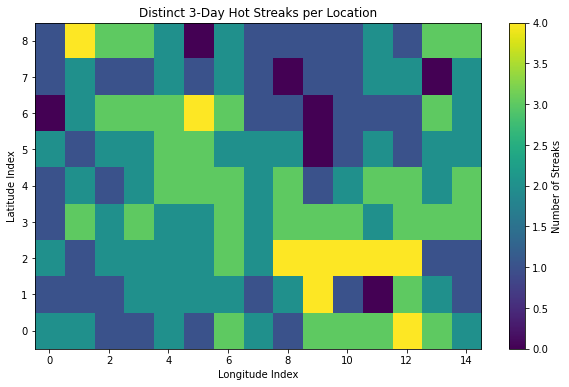

In [102]:
# Step 1: Verify hot days array (already computed)
# print("Hot Days Array (Summary):")
# print(hot_days)

# Step 2: Apply a rolling window to compute streaks
streaks_rolling = (
    hot_days.rolling(day=3, center=False)   # Rolling 3-day window
    .construct("window_dim")                # Create a dimension for the rolling window
    .reduce(np.all, dim="window_dim")       # Check if all values in the window are True
)

# Step 3: Replace NaN values (from rolling) with 0
streaks_rolling_filled = streaks_rolling.fillna(0).astype(int)

# Verify rolling streaks
# print("Rolling Streaks (3-Day):")
# print(streaks_rolling_filled)

# Step 4: Count the number of streaks per location
def count_distinct_streaks(array):
    diff = np.diff(array, axis=0)
    streak_starts = (diff == 1).sum(axis=0)  # Count where a streak begins
    return streak_starts

distinct_streaks = xr.apply_ufunc(
    count_distinct_streaks,
    streaks_rolling_filled,
    input_core_dims=[["day"]],
    vectorize=True
)

# Step 5: Print results
print("Distinct Three-Day Streaks per Location:")
print(distinct_streaks)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Distinct 3-Day Hot Streaks per Location")
plt.imshow(distinct_streaks, origin="lower", aspect="auto")
plt.colorbar(label="Number of Streaks")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


## Creating Target labels for each day (if the next 7 days contain at least 3 hot days)

In [103]:
# Define the rolling window size
window_size = 7

# Count the number of hot days in each rolling window
hot_days_rolling = (
    hot_days.rolling(day=window_size, center=False)
    .construct("window_dim")
    .reduce(np.sum, dim="window_dim")
)

# Create labels: 1 if 3 or more hot days, 0 otherwise
labels_next_7_days = (hot_days_rolling >= 3).astype(int)

# Align the labels with the dataset (shift back by window_size - 1)
labels_next_7_days = labels_next_7_days.shift(day=-(window_size - 1))
# Does this makes sense?????

# Drop NaN values (caused by shifting)
labels_next_7_days = labels_next_7_days.dropna("day")

# Debug: Inspect the rolling sum
print("Rolling sum of hot days over 7-day window:")
print(hot_days_rolling)

# Debug: Inspect the labels before and after shifting
print("Labels before shifting (aligned with future interval):")
print((hot_days_rolling >= 3).astype(int))

print("Labels after shifting (aligned with current day):")
print(labels_next_7_days)

Rolling sum of hot days over 7-day window:
<xarray.DataArray 't2m' (day: 615, latitude: 9, longitude: 15)> Size: 664kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [3, 1, 2, ..., 2, 1, 0],
        [3, 3, 3, ..., 0, 0, 0]],

       [[0, 1, 1, ..., 1, 1, 1],
        [1, 

In [106]:
# Define the feature window size
feature_window_size = 30

# Create rolling windows for features
features_rolling = (
    temp_summer_12.rolling(day=feature_window_size, center=False)
    .construct("feature_dim")
)

# Drop NaN values caused by rolling
features_rolling = features_rolling.dropna("day")

# Align features and labels based on overlapping days
features_rolling, labels_next_7_days = xr.align(features_rolling, labels_next_7_days, join="inner")

# Ensure features and labels are aligned
labels_next_7_days = labels_next_7_days.sel(day=features_rolling["day"])


In [107]:
# Use data from previous years for training
train_features = features_rolling.sel(day=features_rolling["day"].dt.year < 2023)
train_labels = labels_next_7_days.sel(day=labels_next_7_days["day"].dt.year < 2023)

# Use data from 2023 for testing
test_features = features_rolling.sel(day=features_rolling["day"].dt.year == 2023)
test_labels = labels_next_7_days.sel(day=labels_next_7_days["day"].dt.year == 2023)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train = torch.tensor(train_features.values, dtype=torch.float32)
y_train = torch.tensor(train_labels.values, dtype=torch.float32)

# Define a dataset and data loader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the model
class HotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(HotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model
input_size = X_train.shape[1]
model = HotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(10):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")
